# Create main Timeseries object
The following cell combines all the parsed csv's (one per month) from the given folder into a single Timeseries object.

In [1]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
import glob
import matplotlib

from pathlib import Path

register_matplotlib_converters()


# ------ Path containing CSVs to be parsed and merged ------ #
PATH = "minecraft_new_hypixel"
# ---------------------------------------------------------- #

# ------ Path to the manually labeled file ----------------- #
REAL_LABELS_FILE = "minecraft_new_hypixel/labeled/hypixel_all_labeled.csv"
# ---------------------------------------------------------- #


# ------ Resampling frequency ------------------------------ #
RESAMPLE_FREQ = 2 # MINUTES. New sample every X minutes.
# ---------------------------------------------------------- #


all_files = glob.glob(PATH + "/*.csv")

li = []
for filename in all_files:
    ts = pd.read_csv(filename, header=0, parse_dates=[0], index_col=0)
    li.append(ts)

final_ts = pd.concat(li, axis=0, ignore_index=False)
final_ts = final_ts.sort_index()


# # TEMP - REMOVE AFTER USE

# final_ts['day']=final_ts.index.floor('d')
# final_ts['date']=final_ts.index
# final_ts['source']="runescape_A"
# final_ts['ttl']=0
# final_ts.rename(columns={'0':'active_users'}, inplace=True)

# for name, group in final_ts.groupby('day'):
#     folder = f"days/{name.strftime('%Y')}/{name.strftime('%m')}/{name.strftime('%d')}"
#     Path(folder).mkdir(parents=True, exist_ok=True)
#     group.to_csv(folder+'/{}.csv'.format(name.strftime("%Y-%m-%d")), index=False)

# # ---
# exit()



# Resample using globally defined freq
final_ts = final_ts.resample(str(RESAMPLE_FREQ)+"min", level=0).mean()

#Non-interpolated dataset:
raw_ts = final_ts

# Interpolated final Timeseries:
final_ts = final_ts.interpolate()

#final_ts.to_csv('final_ts_runescape.csv')
#deseasonalized = pd.read_csv('RUNESCAPE_DESEASONED2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#deseasonalized = pd.read_csv('MC_MINEHUT_DESEASONED.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# ------------------ OPTIONAL: Truncate dataset to focus on specific period ------------------ #

#final_ts = final_ts.truncate(pd.Timestamp(2007, 10, 1), pd.Timestamp(2015, 3, 22)) # All data
#final_ts = final_ts.truncate(pd.Timestamp(2014, 7, 1), pd.Timestamp(2014, 7, 30))  # Test month
#final_ts = final_ts.truncate(pd.Timestamp(2013, 5, 1), pd.Timestamp(2013, 7, 30))  # Test few months

# -------------------------------------------------------------------------------------------- #
print(final_ts.describe())

                   0
count  209646.000000
mean    86975.671803
std     27456.922104
min         0.000000
25%     66808.475000
50%     83554.958333
75%    104388.225000
max    216434.450000


# Heatmap of player counts

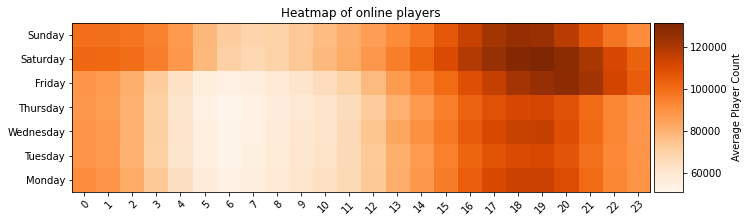

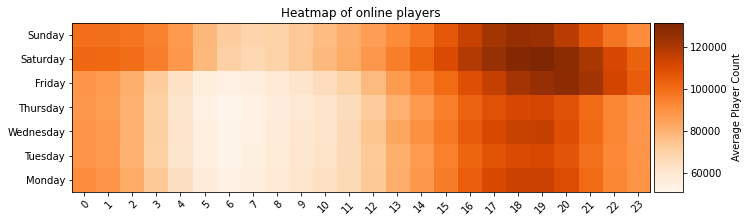

In [2]:
import datetime
import calendar
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

df = pd.DataFrame(final_ts)
df.insert(1, 'weekday', df.index.weekday)
df.insert(2, 'time', df.index.to_series().apply(lambda x: x.replace(day=1, month=1, year=2020)))

lst = []

hours = range(0,24)
weekdays = list(reversed(calendar.day_name))

for wd in range(6, -1, -1):
    ls = []
    for tm in range(0,24):
        ls.append(df['0'].where(np.logical_and(df['time'].dt.hour == tm, df['weekday'] == wd)).mean())
    lst.append(ls)

arr = np.array(lst)

fig, ax = plt.subplots(figsize=(10.5,5.5))
im = ax.imshow(arr, interpolation="nearest", cmap="Oranges")

ax.set_xticks(np.arange(len(hours)))
ax.set_yticks(np.arange(len(weekdays)))

ax.set_xticklabels(hours)
ax.set_yticklabels(weekdays)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Heatmap of online players")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = plt.colorbar(im, cax=cax)
cb.set_label('Average Player Count')
fig.tight_layout()
fig

                                0
timestamp                        
2020-08-01 19:48:00  93971.405405
2020-08-01 19:50:00  93844.375000
2020-08-01 19:52:00  93727.475000
2020-08-01 19:54:00  93780.775000
2020-08-01 19:56:00  93757.400000
...                           ...
2021-05-19 23:50:00  91344.400000
2021-05-19 23:52:00  91343.050000
2021-05-19 23:54:00  91360.925000
2021-05-19 23:56:00  91394.925000
2021-05-19 23:58:00  91404.128205

[209646 rows x 1 columns]


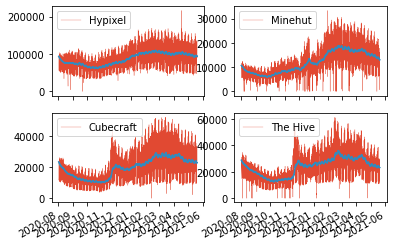

In [3]:
import datetime as dt
import pandas as pd
import matplotlib.dates as dates

ts1 = pd.read_csv('final_ts_hypixel.csv', parse_dates=["timestamp"]).set_index('timestamp')
ts2 = pd.read_csv('final_ts_minehut.csv', parse_dates=["timestamp"]).set_index('timestamp')
ts3 = pd.read_csv('final_ts_cubecraft.csv', parse_dates=["timestamp"]).set_index('timestamp')
ts4 = pd.read_csv('final_ts_hive.csv', parse_dates=["timestamp"]).set_index('timestamp')

print(ts1)
wdw = 10000
exp1 = ts1.ewm(span=wdw, adjust=False).mean()
exp2 = ts2.ewm(span=wdw, adjust=False).mean()
exp3 = ts3.ewm(span=wdw, adjust=False).mean()
exp4 = ts4.ewm(span=wdw, adjust=False).mean()

plt.subplot(221)
plt.plot(ts1, linewidth=0.3, color='#E14932')
plt.plot(ts1.index, exp1, label='Exponential Moving Average', color='#348ABD')
ax = plt.gca()
ax.legend(['Hypixel'])
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%m-\'%y'))
fig = plt.gcf()
fig.autofmt_xdate()

plt.subplot(222)
plt.plot(ts2, linewidth=0.3, color='#E14932')
plt.plot(ts2.index, exp2, label='Exponential Moving Average', color='#348ABD')
ax = plt.gca()
ax.legend(['Minehut'])
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%m-\'%y'))
fig = plt.gcf()
fig.autofmt_xdate()

plt.subplot(223)
plt.plot(ts3, linewidth=0.3, color='#E14932')
plt.plot(ts3.index, exp3, label='Exponential Moving Average', color='#348ABD')
ax = plt.gca()
ax.legend(['Cubecraft'])
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%m-\'%y'))
fig = plt.gcf()
fig.autofmt_xdate()

plt.subplot(224)
plt.plot(ts4, linewidth=0.3, color='#E14932')
plt.plot(ts4.index, exp4, label='Exponential Moving Average', color='#348ABD')
ax = plt.gca()
ax.legend(['The Hive'])
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%m-\'%y'))
fig = plt.gcf()
fig.autofmt_xdate()

#plt.axvline(dt.datetime(2011, 1, 17), color='black', linestyle='--', linewidth="1")
#plt.text(dt.datetime(2011, 1, 17),280000,'Free trade')
#plt.axvline(dt.datetime(2011, 10, 25), color='black', linestyle='--', linewidth="1")

#_ = plt.xticks(rotation=45)

#plt.show()

# Remove Seasonality and Trend from the time series
This cell will decompose the time series into the trend and seasonal components. These are then removed from the original dataset to be left with only the residuals.
Two separate methods are used. The very fast but less thorough 'seasonal_decompose', and the slow but good STL method.
The first method does two passes, to remove both daily and weekly seasonality. This is impractical for the STL method due to time.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL

SAMPLES_PER_DAY = int((24*60) / RESAMPLE_FREQ) # Amount of samples per day is: minutes per day / sample period in minutes.


# ------------ Time Series Decomposition using 'seasonal_decompose' ------------
result_decomp = seasonal_decompose(final_ts, period=SAMPLES_PER_DAY, model="additive")
detrended1 = final_ts.values - result_decomp.trend # Detrend
deseasonalized1 = detrended1.values - result_decomp.seasonal # Deseasonalize
# Second pass for weekly seasonality
result_decomp2 = seasonal_decompose(deseasonalized1.fillna(0), period=SAMPLES_PER_DAY*7, model="additive")
detrended2 = deseasonalized1.values - result_decomp2.trend
deseasonalized_decompose = detrended2.values - result_decomp2.seasonal
# ------------------------------------------------------------------------------


# ------------ Time Series Decomposition using 'STL' ---------------------------
result_stl = STL(final_ts, period=SAMPLES_PER_DAY).fit()
detrended = final_ts.values - result_stl.trend # Detrend
deseasonalized_stl = detrended.values - result_stl.seasonal # Deseasonalize
# ------------------------------------------------------------------------------


# --- CHOOSE which result to use from here on out --- #
deseasonalized = deseasonalized_stl
# --------------------------------------------------- #

#deseasonalized.to_csv('MC_HIVE_DESEASONED.csv')

# --- Plot the results ---
plt.subplot(321)
plt.plot(result_stl.trend)
ax = plt.gca()
ax.legend(['Trend'])
plt.subplot(323)
plt.plot(result_stl.seasonal)
ax = plt.gca()
ax.legend(['Seasonality'])
plt.subplot(325)
plt.plot(result_stl.resid)
ax = plt.gca()
ax.legend(['Residuals'])

plt.subplot(122)
plt.plot(deseasonalized_decompose, linewidth=1, color='#E14932')
plt.plot(deseasonalized_stl, linewidth=1, color="orange")
plt.plot(final_ts, color="blue")
ax = plt.gca()
ax.legend(['seasonal_decompose', 'STL', 'Raw Data'])
plt.show()

In [ ]:
# --- Plot the results ---
plt.subplot(321)
plt.plot(result_stl.trend)
ax = plt.gca()
ax.legend(['Trend'])
plt.subplot(323)
plt.plot(result_stl.seasonal, linewidth=0.1)
ax = plt.gca()
ax.legend(['Seasonality'])
plt.subplot(325)
plt.plot(result_stl.resid, linewidth=0.5)
ax = plt.gca()
ax.legend(['Residuals'])

plt.subplot(122)
plt.plot(deseasonalized_decompose, linewidth=1, color='#E14932')
plt.plot(deseasonalized_stl, linewidth=1, color="orange")
plt.plot(final_ts, color="blue")
ax = plt.gca()
ax.legend(['seasonal_decompose', 'STL', 'Raw Data'])
plt.show()

In [ ]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
# --- Plot the results ---
plt.subplot(222)
plt.plot(result_stl.trend, color="C2", linewidth=0.4)
ax = plt.gca()
ax.set_title('Trend')
ax.set_ylabel('Online Players')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=""))
plt.setp(ax.xaxis.get_majorticklabels(), 'rotation', 90)
plt.subplot(223)
plt.plot(result_stl.seasonal, color="C1", linewidth=0.1)
ax = plt.gca()
ax.set_title('Seasonality')
ax.set_ylabel('Online Players')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=""))
plt.setp(ax.xaxis.get_majorticklabels(), 'rotation', 90)
plt.subplot(224)
plt.plot(result_stl.resid, color="C3", linewidth=0.2)
ax = plt.gca()
ax.set_title('Residuals')
ax.set_ylabel('Online Players')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=""))
plt.setp(ax.xaxis.get_majorticklabels(), 'rotation', 90)

plt.subplot(221)
#plt.plot(deseasonalized_decompose, linewidth=1, color='#E14932')
#plt.plot(deseasonalized_stl, linewidth=1, color="orange")
plt.plot(final_ts, color="C0", linewidth=0.2)
ax = plt.gca()
ax.set_title('Raw Player Count')
ax.set_ylabel('Online Players')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_formatter(ticker.EngFormatter(sep=""))
plt.setp(ax.xaxis.get_majorticklabels(), 'rotation', 90)
plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.subplots_adjust(top=0.87)
fig = plt.gcf()
fig.set_size_inches(6.0,5.5)
plt.show()
plt.savefig('plots/hypixel_decomp.pdf')

# Detect Failures (using Z-scores + peak expansion + bonus peaks)
Find first point with high z-score.

Backtrack point by point, until the diff of this point is suddenly much lower. This is start of peak. Save the Y value of this point.

Find last point with high-zscore.

Look ahead point by point until Y value comes close to the saved Y value (start of peak). This is done via a percentage of the normalized peak height. (Top of peak minus min value of peak) If the course starts reversing (going down again before reaching previous peak height), also stop the lookahead.

To increase recall, points where there is a sudden sharp drop in diff are also marked as peaks, regardless of whether there is a peak in the deseasonalized data or not. 

In [ ]:
from sklearn.metrics import confusion_matrix
from scipy import stats

# -------- Algorithm Parameters ----------------------- #
WINDOW_SIZE = 4333#675            # Number of samples in the window.
Z_THRESHOLD = 4.62#5.5            # Minimum Z-Score for point to be marked as peak.

MAXIMUM_LOOKAHEAD = 720      # Stop expanding peak after X samples if start/end not found yet.
PEAK_START_DIFF_FACTOR = 2.28#4   # Peak start defined as when diff is suddenly at least N times smaller.
PEAK_END_RECOVER_PERC = 0.83#0.65 # Peak end defined when N% of the pre-peak value has been regained.

BONUS_DIFF_THRES = final_ts.mean() / 15.3#19 # The minimum Diff value for a point to be marked as a bonus peak


WINDOW_SIZE = 4784#675            # Number of samples in the window.
Z_THRESHOLD = 4.86#5.5            # Minimum Z-Score for point to be marked as peak.

MAXIMUM_LOOKAHEAD = 720      # Stop expanding peak after X samples if start/end not found yet.
PEAK_START_DIFF_FACTOR = 2.06#4   # Peak start defined as when diff is suddenly at least N times smaller.
PEAK_END_RECOVER_PERC = 0.84#0.65 # Peak end defined when N% of the pre-peak value has been regained.

BONUS_DIFF_THRES = final_ts.mean() / 15.3#19 # The minimum Diff value for a point to be marked as a bonus peak


#[4784, 4.863266543366097, 5757, 2.0560282392446982, 0.8423319799948153]
# -------- PeakData dataframe shape definition -------- #
peakData = pd.DataFrame(columns=[
'group', 
'timespan', 
'magnitude', 
'drop', 
'shape', 
'startdate', 
'enddate', 
'recoverytime',
'pre_slope',
'recovery_slope',
'pre_post_difference'
])
# ----------------------------------------------------- #



def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

def label_dataset(window_size, variance, min_slope_neg, min_slope_pos, max_lookahead, start_diff_factor, end_perc, TEMP_WINDOW):
    # Z-score algorithm to find first set of peaks
    labels = zscore(deseasonalized,window_size)<-variance
    #print(len(labels == True))

    combined_df = pd.DataFrame(final_ts)
   
    combined_df.columns = ["value"] 
    combined_df.insert(1, 'label', labels)
    #combined_df.insert(1, 'label', False)
    #print(combined_df)
    combined_df.insert(2, 'diff', final_ts.diff())
    combined_df.insert(3, 'deseas_diff', deseasonalized.diff())
    combined_df.insert(4, 'deseas_value', deseasonalized)

    # Mark bonus peaks
    combined_df.loc[combined_df['diff'] < -min_slope_neg, 'label'] = True
    combined_df.loc[combined_df['diff'] > min_slope_pos, 'label'] = True

    labels = combined_df['label']

    # Get individual peak 'groups' from the raw per-sample labels
    labels_shifted = labels.shift(1).fillna(False)
    is_edge = labels != labels_shifted
    edges = pd.DataFrame({'data': labels, 'edge': is_edge})
    peakGroups = edges.loc[edges['edge']==True]

    # Expand each peak group to capture entire peak
    for i, g in peakGroups.groupby(np.arange(len(peakGroups)) // 2):
        peakStart = g.index[0]
        peakEnd = g.index[1]

        realPeakStart = []
        realPeakStartValue = 0

        previousDiff = 0
        n = 0 # limit on how far to look back to find start of peak
        currRow = combined_df.loc[peakStart]

        foundStart = False
        while (True and n < max_lookahead):
            currDiff = currRow['diff']

            if (abs(currDiff)*start_diff_factor < abs(previousDiff)):
                # Start of peak found
                realPeakStart = currRow
                realPeakStartValue = currRow['value']
                foundStart = True
                break

            # Check next row
            n += 1
            previousDiff = currDiff
            currRow = combined_df.loc[currRow.name - pd.Timedelta(minutes=RESAMPLE_FREQ)]

        if (not foundStart):
            realPeakStart = currRow
            realPeakStartValue = currRow['value']

        peakMinimum = combined_df.loc[realPeakStart.name:peakEnd, 'value'].min()

        realPeakEnd = []

        n = 0 # limit on how far to look forward to find end of peak
        previousVal = 0
        currRow = combined_df.loc[peakEnd]
        foundEnd = False
        while (True and n < max_lookahead):
            currVal = currRow['value']

            if (currVal-peakMinimum > end_perc * (realPeakStartValue-peakMinimum) or currVal < previousVal):
                # End of peak found
                realPeakEnd = currRow
                foundEnd = True
                break

            # Check next row
            n += 1
            previousVal = currVal
            currRow = combined_df.loc[currRow.name + pd.Timedelta(minutes=RESAMPLE_FREQ)]
        
        if (not foundEnd):
            realPeakEnd = currRow



        # Find recovery times ----
        n = 0 # limit on how far to look forward to find end of peak
        currRow = combined_df.loc[peakEnd]
        foundEnd = False
        recoveryPoint = []
        while (True and n < 2000000):
            currVal = currRow['value']
            currValDeseas = currRow['deseas_value']
            peakMin = combined_df.loc[realPeakStart.name:peakEnd, 'deseas_value'].min()

            #if (currVal-peakMinimum > 0.98 * (realPeakStartValue-peakMinimum)):
            if (currValDeseas-peakMin > 0.98 * (realPeakStart['deseas_value'] - peakMin)):
                # Point of recovery found
                recoveryPoint = currRow
                break

            # Check next row
            n += 1
            previousVal = currVal
            try:
                currRow = combined_df.loc[currRow.name + pd.Timedelta(minutes=RESAMPLE_FREQ)]
            except:
                break
        
        if (not foundEnd):
            recoveryPoint = currRow

        recoveryTime =  recoveryPoint.name - realPeakStart.name
        



        # Set all the sample labels between the real peak start and end to True
        combined_df.loc[realPeakStart.name:realPeakEnd.name-pd.Timedelta(minutes=RESAMPLE_FREQ), 'label'] = True


        # Get advanced statistics
        #pre_slope = combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=30)) : realPeakStart.name - (pd.Timedelta(minutes=10)), 'deseas_diff'].sum()
        pre_slope = combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=5)) : realPeakStart.name, 'deseas_value'].sum()

        recovery_slope = combined_df.loc[combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].idxmin() : realPeakEnd.name, 'diff'].mean()

        pre_post_window_size = TEMP_WINDOW
        pre_post_difference = combined_df.loc[realPeakEnd.name : realPeakEnd.name + (pd.Timedelta(minutes=pre_post_window_size)) , 'deseas_value'].mean() - combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=pre_post_window_size)) : realPeakStart.name, 'deseas_value'].mean()



        # Add this peak and its statistics to the peakData dataframe.
        peakData.loc[i] = pd.Series({'group':i, 
                'timespan':(realPeakEnd.name - realPeakStart.name),
                'magnitude': combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].max() - combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].min(),
                'drop': 100 - (combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].min() / combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].max() * 100), 
                'shape': combined_df.loc[realPeakStart.name:realPeakEnd.name, 'diff'].mean(),
                'startdate': realPeakStart.name, 
                'enddate': realPeakEnd.name,
                'recoverytime': recoveryTime,
                'pre_slope': pre_slope,
                'recovery_slope': recovery_slope,
                'pre_post_difference': pre_post_difference
                })

        
    # Save peak data to a CSV file
    # peakData.to_csv(PATH + '_peaks_extended_' + str(TEMP_WINDOW) + '.csv')
    # print("saved to: " + PATH + '_peaks_extended_' + str(TEMP_WINDOW) + '.csv')
    return combined_df['label']



window_sizes = (5,10,15,20,25,30,35,40,45,50,55,60)

# def test(n):
#    labeled_dataset = label_dataset(WINDOW_SIZE, Z_THRESHOLD, BONUS_DIFF_THRES, BONUS_DIFF_THRES, MAXIMUM_LOOKAHEAD, PEAK_START_DIFF_FACTOR, PEAK_END_RECOVER_PERC, n)

# list(map(test, window_sizes))

# ---- Perform automatic labelling using predefined parameters ----
labeled_dataset = label_dataset(WINDOW_SIZE, Z_THRESHOLD, BONUS_DIFF_THRES, BONUS_DIFF_THRES, MAXIMUM_LOOKAHEAD, PEAK_START_DIFF_FACTOR, PEAK_END_RECOVER_PERC, 15)
# -----------------------------------------------------------------



# Plot results
plt.plot(deseasonalized)
x = np.where(labeled_dataset == True)[0]
plt.plot(final_ts)
plt.plot(deseasonalized.index[x], deseasonalized.values[x], 'ro')
plt.plot(final_ts.index[x], final_ts.values[x], 'ro')

In [118]:
def label_dataset(data_ts, window_size, variance, min_slope_neg, min_slope_pos, max_lookahead, start_diff_factor, end_perc, TEMP_WINDOW):
    # Z-score algorithm to find first set of peaks
    labels = zscore(deseasonalized,window_size)<-variance
    #print(len(labels == True))

    combined_df = pd.DataFrame(data_ts)
   
    combined_df.columns = ["value"] 
    combined_df.insert(1, 'label', labels)
    #combined_df.insert(1, 'label', False)
    #print(combined_df)
    combined_df.insert(2, 'diff', data_ts.diff())
    combined_df.insert(3, 'deseas_diff', deseasonalized.diff())
    combined_df.insert(4, 'deseas_value', deseasonalized)

    # Mark bonus peaks
    combined_df.loc[combined_df['diff'] < -min_slope_neg, 'label'] = True
    combined_df.loc[combined_df['diff'] > min_slope_pos, 'label'] = True

    labels = combined_df['label']

    # Get individual peak 'groups' from the raw per-sample labels
    labels_shifted = labels.shift(1).fillna(False)
    is_edge = labels != labels_shifted
    edges = pd.DataFrame({'data': labels, 'edge': is_edge})
    peakGroups = edges.loc[edges['edge']==True]

    # Expand each peak group to capture entire peak
    for i, g in peakGroups.groupby(np.arange(len(peakGroups)) // 2):
        peakStart = g.index[0]
        peakEnd = g.index[1]

        realPeakStart = []
        realPeakStartValue = 0

        previousDiff = 0
        n = 0 # limit on how far to look back to find start of peak
        currRow = combined_df.loc[peakStart]

        foundStart = False
        while (True and n < max_lookahead):
            currDiff = currRow['diff']

            if (abs(currDiff)*start_diff_factor < abs(previousDiff)):
                # Start of peak found
                realPeakStart = currRow
                realPeakStartValue = currRow['value']
                foundStart = True
                break

            # Check next row
            n += 1
            previousDiff = currDiff
            try:
                currRow = combined_df.loc[currRow.name - pd.Timedelta(minutes=RESAMPLE_FREQ)]
            except:
                foundStart = False
                break

        if (not foundStart):
            realPeakStart = currRow
            realPeakStartValue = currRow['value']

        peakMinimum = combined_df.loc[realPeakStart.name:peakEnd, 'value'].min()

        realPeakEnd = []

        n = 0 # limit on how far to look forward to find end of peak
        previousVal = 0
        currRow = combined_df.loc[peakEnd]
        foundEnd = False
        while (True and n < max_lookahead):
            currVal = currRow['value']

            if (currVal-peakMinimum > end_perc * (realPeakStartValue-peakMinimum) or currVal < previousVal):
                # End of peak found
                realPeakEnd = currRow
                foundEnd = True
                break

            # Check next row
            n += 1
            previousVal = currVal
            try:
                currRow = combined_df.loc[currRow.name + pd.Timedelta(minutes=RESAMPLE_FREQ)]
            except:
                foundEnd = False
                break
        
        if (not foundEnd):
            realPeakEnd = currRow



        # Find recovery times ----
        n = 0 # limit on how far to look forward to find end of peak
        currRow = combined_df.loc[peakEnd]
        foundEnd = False
        recoveryPoint = []
        while (True and n < 2000000):
            currVal = currRow['value']
            currValDeseas = currRow['deseas_value']
            peakMin = combined_df.loc[realPeakStart.name:peakEnd, 'deseas_value'].min()

            #if (currVal-peakMinimum > 0.98 * (realPeakStartValue-peakMinimum)):
            if (currValDeseas-peakMin > 0.98 * (realPeakStart['deseas_value'] - peakMin)):
                # Point of recovery found
                recoveryPoint = currRow
                break

            # Check next row
            n += 1
            previousVal = currVal
            try:
                currRow = combined_df.loc[currRow.name + pd.Timedelta(minutes=RESAMPLE_FREQ)]
            except:
                break
        
        if (not foundEnd):
            recoveryPoint = currRow

        recoveryTime =  recoveryPoint.name - realPeakStart.name
        



        # Set all the sample labels between the real peak start and end to True
        combined_df.loc[realPeakStart.name:realPeakEnd.name-pd.Timedelta(minutes=RESAMPLE_FREQ), 'label'] = True


        # Get advanced statistics
        #pre_slope = combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=30)) : realPeakStart.name - (pd.Timedelta(minutes=10)), 'deseas_diff'].sum()
        pre_slope = combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=5)) : realPeakStart.name, 'deseas_value'].sum()

        recovery_slope = combined_df.loc[combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].idxmin() : realPeakEnd.name, 'diff'].mean()

        pre_post_window_size = TEMP_WINDOW
        pre_post_difference = combined_df.loc[realPeakEnd.name : realPeakEnd.name + (pd.Timedelta(minutes=pre_post_window_size)) , 'deseas_value'].mean() - combined_df.loc[realPeakStart.name - (pd.Timedelta(minutes=pre_post_window_size)) : realPeakStart.name, 'deseas_value'].mean()



        # Add this peak and its statistics to the peakData dataframe.
        peakData.loc[i] = pd.Series({'group':i, 
                'timespan':(realPeakEnd.name - realPeakStart.name),
                'magnitude': combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].max() - combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].min(),
                'drop': 100 - (combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].min() / combined_df.loc[realPeakStart.name:realPeakEnd.name, 'value'].max() * 100), 
                'shape': combined_df.loc[realPeakStart.name:realPeakEnd.name, 'diff'].mean(),
                'startdate': realPeakStart.name, 
                'enddate': realPeakEnd.name,
                'recoverytime': recoveryTime,
                'pre_slope': pre_slope,
                'recovery_slope': recovery_slope,
                'pre_post_difference': pre_post_difference
                })

        
    # Save peak data to a CSV file
    # peakData.to_csv(PATH + '_peaks_extended_' + str(TEMP_WINDOW) + '.csv')
    # print("saved to: " + PATH + '_peaks_extended_' + str(TEMP_WINDOW) + '.csv')
    return combined_df['label']

In [54]:
%matplotlib widget
# Plot results
x = np.where(labeled_dataset == True)[0]
plt.plot(final_ts)
#plt.plot(deseasonalized.index[x], deseasonalized.values[x], 'ro')
plt.plot(final_ts.index[x], final_ts.values[x], 'ro')
plt.xlim([pd.Timestamp(2014, 7, 21), pd.Timestamp(2014, 7, 23)])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(16272.0, 16274.0)

In [60]:
print(final_ts.mean())

86975.6718032525


In [87]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100
data = np.random.uniform(-1, 1, fs)

scaled = np.int16(deseasonalized/np.max(np.abs(final_ts)) * 32767)

#sd.play(scaled, fs)
write('test2.wav', 44100, scaled)

# OPTIONAL: Find optimal parameters for the labeling algorithm

In [67]:
import skopt
from sklearn.metrics import confusion_matrix, cohen_kappa_score

def objective(search_params):
    df_real = pd.read_csv(REAL_LABELS_FILE)
    df_pred = label_dataset(search_params[0], search_params[1], search_params[2], search_params[2], MAXIMUM_LOOKAHEAD, search_params[3], search_params[4], 15).astype(int)
    #tn, fp, fn, tp = confusion_matrix(df_real['label'], df_pred).ravel()
    #f1_score = (tp)/(tp+0.5*(fp+fn))
    #return -1* f1_score
    score = -1* cohen_kappa_score(df_real['label'], df_pred)
    print(score)
    return score

SPACE = [
    skopt.space.Integer(3000, 8000, name='window_size'),
    skopt.space.Real(3, 6.5, name='variability_thres', prior='uniform'),
    skopt.space.Integer(800, 6000, name='bonus_diff_threshold'),
    skopt.space.Real(2, 6, name='start_diff', prior='uniform'),
    skopt.space.Real(0.45, 0.85, name='recovery_perc', prior='uniform')]

def run_optimizer():
    results = skopt.forest_minimize(objective, SPACE, n_calls=100, n_random_starts=10)
    #results = skopt.BayesSearchCV(objective, SPACE, n_calls=300, n_random_starts=10)
    best_auc = -1.0 * results.fun
    best_params = results.x
    print('best result: ', best_auc)
    print('best parameters: ', best_params)

run_optimizer()

-0.34065483269931063
-0.6569757133220248
-0.6866031704158847
-0.5838323505534184
-0.5089672130056266
-0.6345071400607427
-0.4389044558191838
-0.536921556582902
-0.5918207128975426
-0.08311455629573572
-0.7148700804971173
-0.6965073930372688
-0.7110973529089636
-0.7077029204300627
-0.7112091303788736
-0.6931225061925477
-0.6989218146172483
-0.7094382823721725
-0.6878175194230123
-0.7115495763740893
-0.690793431512455
-0.6809599284058818
-0.6523647270782595
-0.6566808038029126
-0.6751900309108088
-0.6182173165089236
-0.5894765074429318
-0.656806531714701
-0.5756953711914126
-0.5852295244916119
-0.6168903057096176
-0.5952854333141956
-0.65932723809063
-0.5179779597989091
-0.17052509079283085
-0.722226355021242
-0.7180278265949402
-0.7259846424675891
-0.713912682274851
-0.7269607734700061
-0.709471456394452
-0.7120333603363367
-0.7120675662132464
-0.6442452639099161
-0.5783096558197103
-0.6024853817316007
-0.3591389845310773
-0.712816931568135
-0.7254287795738112
-0.631848041667326
-0.7410

In [134]:
import skopt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import KFold

REAL_LABELS_FILE1 = "minecraft_new_hypixel/labeled/hypixel_all_labeled.csv"
REAL_LABELS_FILE2 = "minecraft_new_minehut/labeled/minehut_all_labeled.csv"

df_real = pd.read_csv(REAL_LABELS_FILE2)
second_df_real = pd.read_csv(REAL_LABELS_FILE2)

# df_real['timestamp'] = df_real['timestamp'].map(lambda x: pd.to_datetime(x))
# second_df['timestamp'] = second_df['timestamp'].map(lambda x: pd.to_datetime(x) + pd.Timedelta("365 days"))
# df_real.set_index(['timestamp'])
# second_df.set_index(['timestamp'])
# print(second_df)
# df_real = df_real.append(second_df)
# print(df_real)

# plt.plot(df_real['value'])

all_files = glob.glob("minecraft_new_minehut" + "/*.csv")
li = []
for filename in all_files:
    ts = pd.read_csv(filename, header=0, parse_dates=[0], index_col=0, squeeze=True)
    li.append(ts)
fts = pd.concat(li, axis=0, ignore_index=False)
fts = fts.sort_index()

print(fts)

# final_ts = final_ts.append(fts)

def objective(search_params, data_timeseries, test_timeseries):
    #df_real = pd.read_csv(REAL_LABELS_FILE)
    df_pred = label_dataset(data_timeseries, search_params[0], search_params[1], search_params[2], search_params[2], MAXIMUM_LOOKAHEAD, search_params[3], search_params[4], 15).astype(int)
    #tn, fp, fn, tp = confusion_matrix(df_real['label'], df_pred).ravel()
    #f1_score = (tp)/(tp+0.5*(fp+fn))
    #return -1* f1_score
    score = -1* cohen_kappa_score(test_timeseries, df_pred)
    print(score)
    return score

SPACE = [
    skopt.space.Integer(3000, 7000, name='window_size'),
    skopt.space.Real(4, 6.5, name='variability_thres', prior='uniform'),
    skopt.space.Integer(1200, 6000, name='bonus_diff_threshold'),
    skopt.space.Real(2, 3, name='start_diff', prior='uniform'),
    skopt.space.Real(0.45, 0.85, name='recovery_perc', prior='uniform')]

def run_optimizer(datats, testts, valid_split):
    results = skopt.forest_minimize(lambda sp: objective(sp, datats, testts), SPACE, n_calls=10, n_random_starts=10)
    #results = skopt.BayesSearchCV(objective, SPACE, n_calls=300, n_random_starts=10)
    best_auc = -1.0 * results.fun
    best_params = results.x
    print('best result: ', best_auc)
    print('best parameters: ', best_params)
    print('final score on validation set:::')
    objective(best_params, final_ts[valid_split], df_real['label'][valid_split])
    print('final score on other dataset:::')
    #objective(best_params, fts, second_df_real['label'])


# prepare cross validation
kfold = KFold(9, False)
# enumerate splits
for train, test in kfold.split(final_ts):
    run_optimizer(final_tsl_ts[tr, df_real['label'][train], testain#)
	#print('train: %s, test: %s'final_tsdata[traifinal_tsdata[test]#))

run_optimizer()

timestamp
2020-08-01 19:48:09.687    10694.0
2020-08-01 19:48:12.687    10694.0
2020-08-01 19:48:15.687    10688.0
2020-08-01 19:48:18.687    10695.0
2020-08-01 19:48:21.687    10690.0
                            ...   
2021-05-19 23:59:44.490    12483.0
2021-05-19 23:59:47.490    12481.0
2021-05-19 23:59:50.490    12481.0
2021-05-19 23:59:53.491    12481.0
2021-05-19 23:59:56.491    12477.0
Name: 0, Length: 8346171, dtype: float64
-0.6426968394819628
-0.6160694248455862
-0.5889644440874418
-0.5935489426443206
-0.6455286155990452
-0.6183615046755377
-0.6166611573893448
-0.6169724119608444
-0.6502000240925532
-0.6195785047476898
best result:  0.6502000240925532
best parameters:  [4198, 6.217122231497597, 1823, 2.368603336827473, 0.8218885979008674]
final score on validation set:::
-0.4621646321491356
final score on other dataset:::
-0.652227245241509
-0.602973015399344
-0.6244872484538397
-0.6178906881029377
-0.6314969459825581
-0.6461964075128912
-0.6722468738228201
-0.6997564156934089

# Result of the automatic labelling
Shows a confusion matrix and the F-score for the previously performed automatic labelling.
Compared against a manually labeled dataset

In [62]:
import skopt
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


df_real = pd.read_csv(REAL_LABELS_FILE)
df_pred = labeled_dataset.astype(int)

tn, fp, fn, tp = confusion_matrix(df_real['label'].astype(int), df_pred).ravel()
f1_score = (tp)/(tp+0.5*(fp+fn))
print(f1_score)
print(cohen_kappa_score(df_real['label'], df_pred))

cm = confusion_matrix(df_real['label'].astype(int), df_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no peak", "peak"])
disp = disp.plot(include_values=["no peak", "peak"], values_format="")
plt.show()

0.7724631202503353
0.7712466124406792


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
print(final_ts.describe())

count    2.004768e+06
mean     9.905085e+04
std      4.906139e+04
min     -1.000000e+00
25%      5.839800e+04
50%      9.085100e+04
75%      1.333520e+05
max      2.788610e+05
Name: 0, dtype: float64
